In [1]:
import pandas as pd

import xml.etree.ElementTree as ET

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import skipgrams
from nltk.stem import WordNetLemmatizer
from nltk.data import load

import random
import functools
import string
import math
import json
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx
from networkx.readwrite import json_graph

# Data manipulation
In this section the xml data will be converted to a panda dataframe. This is done with the help of a Parser. The parser provides us with:
- getText(datalocation): the function is used to extract text tag values from every record. 
- addFeatureFromText(text,feature,skipString,nextLine,collectNext,featureKeyName): adds features derived from the text tag to the features directory 
- getDataframe(): returns a populated/empty Dataframe object. It depends on the number features that we already extracted
- removeEmptyEntries(dataframeObject, column): removes empty rows or the ones which contain "NaN"

The XMLDataframeParser methods can be found on: https://github.com/LaertNuhu/MedDataVisualisation/blob/master/py/dataManipulation.py

In [2]:
from py.dataManipulation import XMLDataframeParser

parser = XMLDataframeParser()
text = parser.getText("./data/smokingRecords.xml")
parser.addFeatureFromText(text, "HISTORY OF PRESENT ILLNESS :", "", True, True,"illness")
df = parser.getDataframe()
df_xml = parser.removeEmptyEntries(df,"illness")

# Data Normalisation

In this section we are going to start preparing for text normalisation. 
Here we will split the text recived from pandas dataframe into tokens. Transform them into lowercase and remove any characters which are non alfabetical. This is a decision that was made for the simple reason that nonalfabetical information is redundant in this case. For features like 'history course' numerical characters could be important for the analysis, but for the 'history of present illness' feature is not.

The text, which is on english, will be cleaned from stop words. At the end we also need only the stem of the words. 
By normalisation we try to have a clean and uniformal structure of text.

The above actions are all covered by [normalize and normalizeArray](https://github.com/LaertNuhu/MedDataVisualisation/blob/dev/py/normalize.py) functions.

An example of the functions used by these methods can be seen on the following blocks:

In [3]:
# import the Normalizer class from normalize package
from py.normalize import Normalizer
normalizer = Normalizer()

In [4]:
# we take a snippet from our dataframe
text = df_xml["illness"][1][:338]
print(text)

The patient is an 80-year-old male , who had a history of colon cancer in the past , resected approximately ten years prior to admission , history of heavy alcohol use , who presented with a two week history of poor PO intake , weight loss , and was noted to have acute on chronic Hepatitis by chemistries and question of pyelonephritis .


In [5]:
# tokenizer example
#text = "The 3 quick brown foxes are jumping over the fence. Dog barks. Now there are 3 foxes against the dog."
tokenizer = normalizer.tokenize(text)
print(tokenizer)

['The', 'patient', 'is', 'an', '80-year-old', 'male', ',', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', ',', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', ',', 'history', 'of', 'heavy', 'alcohol', 'use', ',', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'PO', 'intake', ',', 'weight', 'loss', ',', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'Hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '.']


In [6]:
# lowercase transformation
lowercaseTokens = normalizer.toLowerCase(tokenizer)
print(lowercaseTokens)

['the', 'patient', 'is', 'an', '80-year-old', 'male', ',', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', ',', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', ',', 'history', 'of', 'heavy', 'alcohol', 'use', ',', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'po', 'intake', ',', 'weight', 'loss', ',', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '.']


In [7]:
# remove punctuation from token array
noPunctuations = normalizer.removePunctuation(tokenizer)
print(noPunctuations)

['The', 'patient', 'is', 'an', '80yearold', 'male', '', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', '', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', '', 'history', 'of', 'heavy', 'alcohol', 'use', '', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'PO', 'intake', '', 'weight', 'loss', '', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'Hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '']


In [8]:
# remove non alphabetic characters
noAlpha = normalizer.removeNonAlpha(tokenizer)
print(noAlpha)

['The', 'patient', 'is', 'an', 'male', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', 'history', 'of', 'heavy', 'alcohol', 'use', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'PO', 'intake', 'weight', 'loss', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'Hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis']


In [9]:
# remove stop words
noStopWords = normalizer.removeStopWords(tokenizer)
print(noStopWords)

['The', 'patient', '80-year-old', 'male', ',', 'history', 'colon', 'cancer', 'past', ',', 'resected', 'approximately', 'ten', 'years', 'prior', 'admission', ',', 'history', 'heavy', 'alcohol', 'use', ',', 'presented', 'two', 'week', 'history', 'poor', 'PO', 'intake', ',', 'weight', 'loss', ',', 'noted', 'acute', 'chronic', 'Hepatitis', 'chemistries', 'question', 'pyelonephritis', '.']


In [10]:
# get tokens stemm
stemmed = normalizer.stemTokens(tokenizer)
print(stemmed)

['the', 'patient', 'is', 'an', '80-year-old', 'male', ',', 'who', 'had', 'a', 'histori', 'of', 'colon', 'cancer', 'in', 'the', 'past', ',', 'resect', 'approxim', 'ten', 'year', 'prior', 'to', 'admiss', ',', 'histori', 'of', 'heavi', 'alcohol', 'use', ',', 'who', 'present', 'with', 'a', 'two', 'week', 'histori', 'of', 'poor', 'PO', 'intak', ',', 'weight', 'loss', ',', 'and', 'wa', 'note', 'to', 'have', 'acut', 'on', 'chronic', 'hepat', 'by', 'chemistri', 'and', 'question', 'of', 'pyelonephr', '.']


In [11]:
# get tokens lemma
lemmatized = normalizer.lemmatizeVerbs(tokenizer)
print(lemmatized)

['The', 'patient', 'be', 'an', '80-year-old', 'male', ',', 'who', 'have', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', ',', 'resect', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', ',', 'history', 'of', 'heavy', 'alcohol', 'use', ',', 'who', 'present', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'PO', 'intake', ',', 'weight', 'loss', ',', 'and', 'be', 'note', 'to', 'have', 'acute', 'on', 'chronic', 'Hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '.']


# Data exploration
In this section we start with the first step of data analysis. Here we do intial data exploration analysis. 

Steps:
 1. Calculate how many tokens has the document
 2. which are the most frequent words
 3. calulate words frequency using tf-idf
 4. compare the results between 2 and 3
 5. which are the most frequent word pairs?
 6. do the same as 3 but for word pairs
 7. use skipgramms
 8. compare results


### 1. Total words count
The countWords function is used to find out how many tokens are on our dataset after cleaning it. 

In [12]:
def countWords(data,lemmatized,POS):
    count=0
    normalizedArray = normalizer.normalizeArray(data,lemmatized,POS)
    for tokenArray in normalizedArray:
        for token in tokenArray:
            count+=1
    return count

In [13]:
# count tokens
totalTokenCount = countWords(df_xml["illness"],False,False)
print('Total tokens: %d' % (totalTokenCount))

Total tokens: 31632


### 2a. Word occurence process example
1. Create a CountVectorizer Object

In [14]:
vectorizer = CountVectorizer()

2. fit data and transform it to a document term matrix

In [15]:
# count vectorizer ignores every token with a length smaller than 2
bag_of_words = vectorizer.fit_transform(["There is a cat","There is a dog","Dog barks"])
print(bag_of_words.toarray())

[[0 1 0 1 1]
 [0 0 1 1 1]
 [1 0 1 0 0]]


3. Sum matrix verticaly

In [16]:
# axis 0 is the vertical axis
# returns a matrix
sum_words = bag_of_words.sum(axis=0)
print(sum_words)

[[1 1 2 2 2]]


4. Map tokens to the sum_words list

In [17]:
# vocabulary_.items() returns a dictionary with the token and its index
# tokens are sorted alphabeticaly in the matrix
vectorizer.vocabulary_.items()

dict_items([('there', 4), ('is', 3), ('cat', 1), ('dog', 2), ('barks', 0)])

In [19]:
# map token to ocunt
words_frequency = []
for token,idx in vectorizer.vocabulary_.items():
    words_frequency.append((token,sum_words[0,idx]))
    print('count of "%s" is %s' % (token,sum_words[0,idx]))

count of "there" is 2
count of "is" is 2
count of "cat" is 1
count of "dog" is 2
count of "barks" is 1


In [20]:
# sort words frequency list
print("Unsorted: %s" % words_frequency)
words_frequency_sorted = sorted(words_frequency, key = lambda x: x[1], reverse=True)
print("Sorted after count: %s" % words_frequency_sorted)

Unsorted: [('there', 2), ('is', 2), ('cat', 1), ('dog', 2), ('barks', 1)]
Sorted after count: [('there', 2), ('is', 2), ('dog', 2), ('cat', 1), ('barks', 1)]


In [21]:
# limit the list output
# based on tokens
n = 2 # the first two tokens
print(words_frequency_sorted[:n])
# based on count
t = 2 # tokens with count higher or the same as 2
print(list(filter(lambda x: x[1]>=t,words_frequency_sorted)))

[('there', 2), ('is', 2)]
[('there', 2), ('is', 2), ('dog', 2)]


### 2b. Words occurency using [SKlearn Bib](https://scikit-learn.org/stable/)
Quick Info:
Using SKlearn CountVectorizer to count word frequencies and as tokenizer we use the normalize function (can be found by data normalisation paragraph). 
The reason for that is because CountVectorizer doesn't support stemming out of the box. We assign the tokenizer parameter with our normalize function which gives stemmed/lemmatized tokens as a result

Content: 
1. getFirstNWords()
2. getFirstWordsWithCountGreater()
3. buildPlot()
4. Most frequent words Graph

### 2b 1. getFirstNWords function: 
- takes the vectorizer, the documents form panda dataframe and the number of rows which will be included
- is the function which does the fit and transformation of the data. 
- the sorting is also done here, giving the top most frequent tokens, n-grams

Parameter explenation:
- vec: takes an Vectorizer Object
- data: takes a data stream. In our case we give here as input the pandas dataframe colum wich we want to analyse
- n: stands for the number of results that we want to have. For example the first 10 most frequent words would mean a n of 10

returns a list of zips. (a,b) were a is the word/words and b is the count

### Word frequency
Quick Info:
Usind SKlearn CountVectorizer to count word frequencies and as tokenizer we use the normalize function (can be found by data normalisation paragraph). 
The reason for that is because CountVectorizer doesn't support stemming out of the box and for that we assign the tokenizer parameter with our function which gives stemmed tokens

#### getFirstNWords function: 
- takes the vectorizer, the documents form panda dataframe and the number of rows which will be included
- is the function which does the fit and transformation of the data. 
- the sorting is also done here, giving the top most frequent tokens, n-grams

Parameter explenation:
- vec: takes an Vectorizer Object
- data: takes a data stream. In our case we give here as input the pandas dataframe colum wich we want to analyse
- n: stands for the number of results that we want to have. For example the first 10 most frequent words would mean a n of 10

returns a list of zips. (a,b) were a is the word/words and b is the count

In [22]:
def getFirstNWords(vec,data,n):
    bag_of_words = vec.fit_transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq_sorted[:n]

### 2b 2. getFirstWordsWithCountGreater function:
- takes the vectorizer, the documents form panda dataframe and the number of rows which will be included
- is the function which does the fit and transformation of the data.
- the sorting is also done here, giving the top most frequent tokens whose count is grater than the threshold t, n-grams

Parameter explenation:
- vec: takes an Vectorizer Object
- data: takes a data stream. In our case we give here as input the pandas dataframe colum wich we want to analyse
- t: stands for the threshold. For example we want words that have a count grater than 10, in wich case t would be 10

returns a list of zips. (a,b) were a is the word/words and b is the count

In [ ]:
def getFirstWordsWithCountGreater(vec,data,t):
    bag_of_words = vec.fit_transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return filter(lambda x: x[1]>=t,words_freq_sorted)

### 2b 3. buildPlot function:
the buildPlot function as the name already says it creates a plot.

Parameter explenation:
- freqWords: is a List containing elements (a,b) where a is one word, or many words depending what we want to count and b is the count of the word/words

In [23]:
def buildPlot(freqWords):
    labels, values = zip(*freqWords)
    indexes = np.arange(len(labels))
    plt.figure(figsize=(15,10))
    plt.xticks(indexes, labels)
    plt.bar(indexes, values)
    plt.xticks(rotation=90)
    plt.xlabel('tokens')
    plt.ylabel('count')
    plt.show()

### 2b 4. Most frequent words graph

Firstly we create a CountVectoizer Object. Then we get the top 10 most frequent words using getFirstNWords function. Last step is to visualize the result using a bar plot.

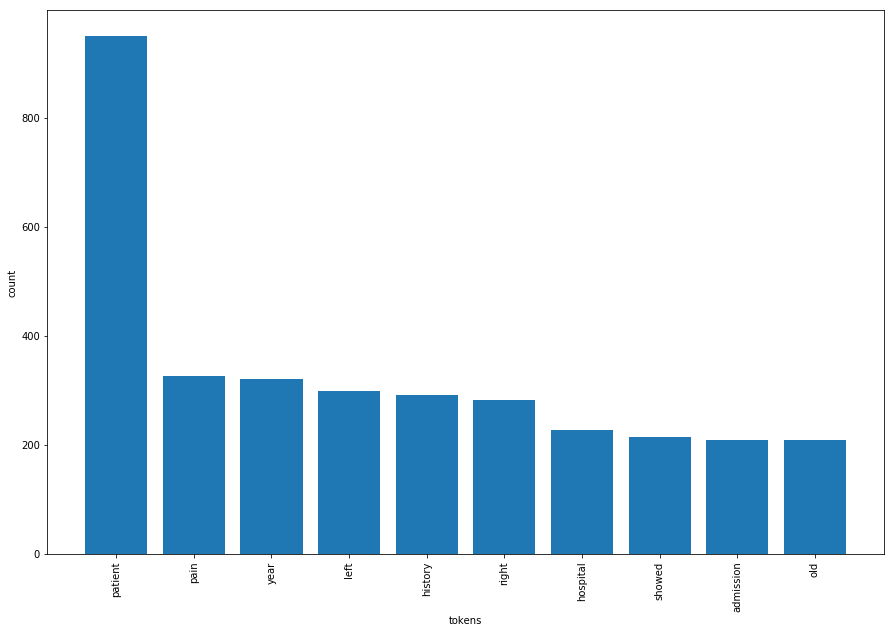

In [26]:
# Firstly creating a CountVectoizer Object
vec = CountVectorizer(tokenizer=lambda text: normalizer.normalize(text, True,False))
mostFreqWords = getFirstNWords(vec,df_xml.illness,10)
buildPlot(mostFreqWords)

In [28]:
mostFreqWordsDf = pd.DataFrame(mostFreqWords,columns = ["token","count"])
mostFreqWordsDf.set_index('token', inplace=True)
mostFreqWordsDf.style.bar(subset=["token","count"], color='#4286f4')

,count
token,
patient,949
pain,327
year,321
left,299
history,291
right,282
hospital,228
showed,215
admission,209


## TFIDF method for comparison

TF-IDF gives high scores to terms occurring in only very few documents, and low scores for terms occurring in many documents, so its roughly speaking a measure of how discriminative a term is in a given document.

In [ ]:
vecTfidf = TfidfVectorizer(
        tokenizer=normalize,
        stop_words='english',
        analyzer='word',
        ngram_range=(1, 1),
        max_df=1.0, min_df=1, 
        max_features=None
        )
mostFreqWords = getFirtsNWords(vecTfidf,df_xml.illness,10)
buildPlot(mostFreqWords)

# Week 2

### 2-Grams
In this section we will compute word frequencies and the tfidf scores for 2 grams.
The structure is the same as 1-gram but in this case we will change the ngram_range to (2,2). That will result in counting 2-grams.

##### Word Frequency

In [ ]:
vec2Gram = CountVectorizer(
        tokenizer=normalize,
        stop_words='english',
        analyzer='word',
        ngram_range=(2, 2),
        max_df=1.0, min_df=1, 
        max_features=None
        )
mostFreq2Grams = getFirtsNWords(vec2Gram,df_xml.illness,10)
buildPlot(mostFreq2Grams)

##### TfIdf Scores

In [ ]:
vecTFIDF2Gram = TfidfVectorizer(
        tokenizer=normalize,
        stop_words='english',
        analyzer='word',
        ngram_range=(2, 2),
        max_df=1.0, min_df=1, 
        max_features=None
        )
mostFreqTFIDF2Grams = getFirtsNWords(vecTFIDF2Gram,df_xml.illness,10)
buildPlot(mostFreqTFIDF2Grams)

### Skip-Gram Implementation (First method)

To achive this we need to customize our Vectorizer. 

Firstly we create a customized CountVectorizer. Problem here is that we cannot decide how many tokens can be skiped, or at least I haven't understood that form the example Code

Explemnation what each method does:
    - sliding_window(k,tokens)
        - k is the number of n-grams and tokens is a list of words.
        - Example: sliding_window(3,["hello","hi","miki","m","ti","ni"]) givs us a 3-gram
    - pluck(index_array, ngram_zip):
        - the index_array gives us the indexes which will be taken into consideration. For Example:
            - array = ["one","2","three"] and the index_array = [0,2] then the array[1] value will be excluded
    - compose(f,g)(x):
        - composes functions -> f(g(x))

##### Problem
Problem here is with the pluck method. It is static and if we want to skip the first element or the last element and not allways the middle ones it does not work. Better Solution to bee found

In [ ]:
from toolz import itertoolz, compose
from toolz.curried import map as cmap, sliding_window, pluck
class SkipGramVectorizer(CountVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

In [ ]:
vec2SkipGram = SkipGramVectorizer(
    tokenizer=normalize,
    stop_words='english',
    analyzer='word',
    max_df=1.0, min_df=1, 
    max_features=None
)

mostFreq2SkipGrams = getFirtsNWords(vec2SkipGram,df_xml.illness,10)
buildPlot(mostFreq2SkipGrams)

Next step is to create the same implementation for the tfidfVectorizer. 

In [ ]:
class SkipGramTFIDFVectorizer(TfidfVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

In [ ]:
vecTFIDF2SkipGram = SkipGramTFIDFVectorizer(
    tokenizer=normalize,
    stop_words='english',
    analyzer='word',
    max_df=1.0, min_df=1, 
    max_features=None
)

mostFreqTFIDF2SkipGrams = getFirtsNWords(vecTFIDF2SkipGram,df_xml.illness,10)
buildPlot(mostFreqTFIDF2SkipGrams)

### A better solution for skip gram is the next method.
NLTK has a library for skipgrams (from nltk.util import ngrams).
The above code has been mostly oriented on the solution presented on https://stackoverflow.com/questions/39725052/is-there-any-way-implementing-skip-gram-with-scikit-learn. 

## Skipgram Implementation (Method 2)
In this phase we will use a combination of nltk skipgram and assign it as an analyser function. We also need to change the normalize function so that it works for our data structure.

The normalizeArray function is a extenction of normalize function which we did define on the normalize section.
The reason why we need to change the normalize function is bacause the skipper function only accepts 2d lists of tokens and not a 1d list of sentences as by normalize function. 

In [ ]:
# the normalize function for Skipgrams.
# change was needed bacause the skipper function accepts only 2d lists of tokens and not sentences.
def normalizeArray(data):
    text = [word_tokenize(line.strip()) for line in data]
    newText = []
    for tokenArray in text:
        tokens = [w.lower() for w in tokenArray]
        import string
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        # stemming of words
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in words]
        newText.append(stemmed)
    return newText

Here we create the skipper funtion. We take skipgrams function from nltk.util. The skipgrams function accepts 2 parameters.
n: is the number of n-grams. Minimum is 2 bacause using skipgrams for 1-grams does not make sense. 
k: is the number of allowed tokens to be skiped. It is randomized and can be in the scale of 0 and windows_size.

In [ ]:
window_size = 10
skipper = functools.partial(skipgrams, n=2, k=random.randint(0,window_size))

Firsly we need to apply the normalizeArray function to our data and we save that to a variable called text. We will be able to use this varible multiple times.

In [ ]:
text = normalizeArray(df_xml.illness)

The next 3 lines are the same as what we saw before. Also we create a vectorizer object. In this case we define the analyser to be skipper. Than we get the list of zips by using the getFirstNWords function and give that as an input to the bulidPlot function. 

In [ ]:
vectorizerRealData = CountVectorizer(analyzer=skipper,stop_words='english')
testVectRealData = getFirtsNWords(vectorizerRealData,text,10)
buildPlot(testVectRealData)

now the same can be done also for the tfidf method

In [ ]:
vectorizerTFIDFRealData = TfidfVectorizer(analyzer=skipper,stop_words='english')
testVectTFIDFRealData = getFirtsNWords(vectorizerTFIDFRealData,text,10)
buildPlot(testVectTFIDFRealData)

#### Check the Toy examlpe for the test dataset example, in order to explain

# Week 3
In this week the main focus is to construct the graph dataframe. We will use NetworkX for that reason.
Firslty we will do some experimentations in order to understand how NetworkX works.


We firstly start with a limited data. We take only 10 entries

In [ ]:
d = [(('year', 'old'), 202), (('patient', 'year'), 139), (('medic', 'center'), 132), (('patient', 'old'), 125), (('chest', 'pain'), 105), (('short', 'breath'), 87), (('prior', 'admiss'), 83), (('old', 'femal'), 81), (('patient', 'histori'), 80), (('day', 'admiss'), 78)]


Only for this small examlpe we create a function to add nodes on the networX graph

In [ ]:
def addEdges(data,graph):
    for element in data:
        graph.add_edge(element[0][0],element[0][1],weight=element[1])
    return graph

In [ ]:
G = nx.Graph()
addEdges(d,G)
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G, k=1,iterations=10)  # positions for all nodes
# nodes
nx.draw_networkx_nodes(G, pos, node_size=5000)

# edges
nx.draw_networkx_edges(G, pos, width=10)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
plt.axis('off')
plt.show()

# Testing with real data

Before we try to test with real data we will try to make our work a little easier in wich we create a pandas dataframe for our graph. The dataframe has these columns:

1. Node1 -> the source
2. Node2 -> the target
3. Weigth -> the edge weigth

In [ ]:
def createDataframe(data):
    node1 = []
    node2 = []
    weight = []
    for entry in data:
        node1.append(entry[0][0])
        node2.append(entry[0][1])
        weight.append(entry[1])
    df = pd.DataFrame()
    df['Node1']=node1
    df['Node2']=node2
    df['Weight']= weight
    return df

we save the dataframe into a variable

In [ ]:
df_graph = createDataframe(testVectRealData)

we create the graph and save it at GF

In [ ]:
GF = nx.from_pandas_edgelist(df_graph, 'Node1', 'Node2', ["Weight"])

Next we will start with d3 implementation. For that reason we need a json file for our data. The rest will be in javascript and it will be uploaded on a webserver.

We create a node-link format and save it at d and the d content is writen on force.json file

In [ ]:
# write json formatted data
d = json_graph.node_link_data(GF)  # node-link format to serialize
# write json
json.dump(d, open('force.json', 'w'))

### Node importance
##### As seen on https://necromuralist.github.io/data_science/posts/node-importance/

this is some extra data that we will be able to use and give a better visualisation from D3.

In [ ]:
degree_centrality = nx.degree_centrality(GF)
closeness_centrality = nx.closeness_centrality(GF)
# write json
degree_centrality_json = {"degree_centrality":degree_centrality}
closeness_centrality_json = {"closeness_centrality":closeness_centrality}

### Extend force.json
We do this so that we have in one file all the needed data.

In [ ]:
with open('force.json') as f:
    data = json.load(f)

data.update(degree_centrality_json)
data.update(closeness_centrality_json)

with open('force.json', 'w') as f:
    json.dump(data, f)

### Function for manipulating json data
This function will include the previosly mentioned steps. Firstly creating the host json file in which the nodes the edges and the weigths are contained. Then the second step consist on extending this host json file with properties of network like the two centralities

In [ ]:
def generateNetworkVisualisationData(name,graph):
    dataExtension = "json"
    name = name + "." + dataExtension
    data = json_graph.node_link_data(graph)
    degree_centrality = nx.degree_centrality(GF)
    closeness_centrality = nx.closeness_centrality(GF)
    degree_centrality_json = {"degree_centrality":degree_centrality}
    closeness_centrality_json = {"closeness_centrality":closeness_centrality}
    data.update(degree_centrality_json)
    data.update(closeness_centrality_json)
    json.dump(data, open(name, 'w'))

In [ ]:
#test 
generateNetworkVisualisationData("figaro",GF)

# Visualisation can be seen on http://eastsidegame.club/bachelor
A little hint: The data on server will be updated reguraly util we dicide the visualisation is optimal. For that reason is allways good to clean your caches/cookes before you access the page or simply open the page at a incognito tab. 

# Week 4

Here we are still going to work on optimizing our data and making the network vizualisation better. 
Other features will be normaly added afer we get a feedback from the professor.


#### Connected components relation to the thrashhold t
A connected component of an undirected graph is a maximal set of nodes such that each pair of nodes is connected by a path.

In [ ]:
vectorizerRealData = CountVectorizer(analyzer=skipper,stop_words='english')
mostFreqWords2 = getFirstWordsWithCountGreater(vectorizerRealData,text,0)
df_graph2 = createDataframe(mostFreqWords2)
GF2 = nx.from_pandas_edgelist(df_graph2, 'Node1', 'Node2', ["Weight"])
graphs = nx.number_connected_components(GF2)
print(graphs)

In [ ]:
def connectedComponentsToThrashold (n):
    result = []
    connectedComponentsNumberArray = []
    tresholdArray = []
    for x in range(n+1):
        mostFreqWords2 = getFirstWordsWithCountGreater(vectorizerRealData,text,x)
        df_graph2 = createDataframe(mostFreqWords2)
        GF2 = nx.from_pandas_edgelist(df_graph2, 'Node1', 'Node2', ["Weight"])
        
        # create multiple json graph based on the threshold n
        #fileName="figaro"+ str(x)
        #generateNetworkVisualisationData(fileName,GF)
        
        connected_components_number = nx.number_connected_components(GF2)
        connectedComponentsNumberArray.append(connected_components_number)
        tresholdArray.append(x)
    result.append(tresholdArray)
    result.append(connectedComponentsNumberArray)
    return result

In [ ]:
pltCoordiantesCCtoTh = connectedComponentsToThrashold(200)

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('Threshold')
plt.ylabel('Connected Components')
indexes = np.arange(len(pltCoordiantesCCtoTh[0]),step=1)
plt.plot(pltCoordiantesCCtoTh[0], pltCoordiantesCCtoTh[1],LineWidth=1)
z = np.polyfit(pltCoordiantesCCtoTh[0], pltCoordiantesCCtoTh[1], 2)
p = np.poly1d(z)
plt.plot(pltCoordiantesCCtoTh[0],p(pltCoordiantesCCtoTh[0]),"r",LineWidth=5)
plt.show()

#### graph diameter relation to threshold
The diameter of a graph is the maximum eccentricity of any vertex in the graph. That is, it is the greatest distance between any pair of vertices. To find the diameter of a graph, first find the shortest path between each pair of vertices. The greatest length of any of these paths is the diameter of the graph.

###### problem if graph is disconected
if graph is disconected the diameter is infinite

In [ ]:
def diameterToThrashold (n):
    import sys
    result = []
    diameterArray = []
    tresholdArray = []
    for x in range(n+1):
        mostFreqWords2 = getFirstWordsWithCountGreater(vectorizerRealData,text,x)
        df_graph2 = createDataframe(mostFreqWords2)
        GF2 = nx.from_pandas_edgelist(df_graph2, 'Node1', 'Node2', ["Weight"])
        largest_connected_component = max(nx.connected_component_subgraphs(GF2), key=len)
        diameter = nx.diameter(largest_connected_component)
        diameterArray.append(diameter)
        tresholdArray.append(x)
    result.append(tresholdArray)
    result.append(diameterArray)
    return result

In [ ]:
pltCoordiantesDitoTh = diameterToThrashold(200)

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('Threshold')
plt.ylabel('Diameter')
plt.plot(pltCoordiantesDitoTh[0], pltCoordiantesDitoTh[1],LineWidth=1)
z = np.polyfit(pltCoordiantesDitoTh[0], pltCoordiantesDitoTh[1], 3)
p = np.poly1d(z)
plt.plot(pltCoordiantesDitoTh[0],p(pltCoordiantesDitoTh[0]),"r",LineWidth=5)
plt.show()

#### Density as a relation to threshold
density = no of edges/total no of possible edges.

d=2m/n(n−1), where m is the number of edges and n is the number of nodes

In [ ]:
def densityToThrashold (n):
    import sys
    result = []
    densityArray = []
    tresholdArray = []
    for x in range(n+1):
        mostFreqWords2 = getFirstWordsWithCountGreater(vectorizerRealData,text,x)
        df_graph2 = createDataframe(mostFreqWords2)
        GF2 = nx.from_pandas_edgelist(df_graph2, 'Node1', 'Node2', ["Weight"])
        density = nx.density(GF2)
        densityArray.append(density)
        tresholdArray.append(x)
    result.append(tresholdArray)
    result.append(densityArray)
    return result

In [ ]:
pltCoordiantesDentoTh = densityToThrashold(200)

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('Threshold')
plt.ylabel('Density')
plt.plot(pltCoordiantesDentoTh[0], pltCoordiantesDentoTh[1])
z = np.polyfit(pltCoordiantesDentoTh[0], pltCoordiantesDentoTh[1], 2)
p = np.poly1d(z)
plt.plot(pltCoordiantesDentoTh[0],p(pltCoordiantesDentoTh[0]),"r",LineWidth=5)
plt.show()

In [ ]:
def clusterCoeffToThrashold (n):
    import sys
    result = []
    clusterArray = []
    tresholdArray = []
    for x in range(n+1):
        mostFreqWords2 = getFirstWordsWithCountGreater(vectorizerRealData,text,x)
        df_graph2 = createDataframe(mostFreqWords2)
        GF2 = nx.from_pandas_edgelist(df_graph2, 'Node1', 'Node2', ["Weight"])
        clustercoeff = nx.average_clustering(GF2)
        clusterArray.append(clustercoeff)
        tresholdArray.append(x)
    result.append(tresholdArray)
    result.append(clusterArray)
    return result

In [ ]:
pltCoordiantesClustoTh = clusterCoeffToThrashold(200)

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel('Threshold')
plt.ylabel('Cluster Coefficient')
plt.plot(pltCoordiantesClustoTh[0], pltCoordiantesClustoTh[1])
z = np.polyfit(pltCoordiantesClustoTh[0], pltCoordiantesClustoTh[1], 2)
p = np.poly1d(z)
plt.plot(pltCoordiantesClustoTh[0],p(pltCoordiantesClustoTh[0]),"r",LineWidth=5)
plt.show()

In [ ]:
print(nx.info(GF2))

In [ ]:
from networkx.algorithms import community
parts = community.girvan_newman(GF2)

In [ ]:
# the normalize function for Skipgrams in case we want to do part of speech tagging
def normalizeArrayPartOfSpeech(data):
    text = [word_tokenize(line.strip()) for line in data]
    newText = []
    for tokenArray in text:
        tokens = [w.lower() for w in tokenArray]
        import string
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        
        #trying lemmatization
        #lemmatizer = WordNetLemmatizer()
        #lemmatized = [lemmatizer.lemmatize(word) for word in words]
        #lemmatized=nltk.pos_tag(lemmatized)
        #newText.append(lemmatized)
        
        # stemming of words
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in words]
        stemmed=nltk.pos_tag(stemmed)
        newText.append(stemmed)
        
    return newText

In [ ]:
text2 = normalizeArrayPartOfSpeech(df_xml.illness)

In [ ]:
print(text2)

### converting the normalized text with the pos tag to a json file
this two new files will be used to visualize POS tags in the networks

In [ ]:
def generatePOSTagJson(text):
    # convert nd array to 1d
    nDimens = np.array(text)
    oneDimens = np.concatenate(nDimens)
    # interate throught every entry
    data = {}
    for entry in oneDimens:
        data[entry[0]]=entry[1]
    json.dump(data, open("POSTag.json", 'w'))

In [ ]:
generatePOSTagJson(text2)

In [ ]:
def generateTAGColorJson():
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    data = {}
    tags = tagdict.keys()
    for tag in tags:
        color = "%06x" % random.randint(0, 0xFFFFFF)
        data[tag] = "#"+color
    json.dump(data, open("TAGColor.json", 'w'))

In [ ]:
generateTAGColorJson()

## community detection 
using the louvain method

In [ ]:
import community

partition = community.best_partition(GF)
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(GF)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(GF, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(GF, pos, alpha=0.5)

plt.show()

In [ ]:
print("Partitions found: ", len(set(partition.values())))

In [ ]:
# read graph from json file
def readGraphFromJson(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [ ]:
# get partitions from saved graphs
def getPartitions(filename):
    graph = readGraphFromJson(filename)
    partition = community.best_partition(graph)
    return partition, len(set(partition.values()))

In [ ]:
for x in range(1,7):
    partition = getPartitions("force_"+str(x)+"00.json")
    result = {}
    result["partition"] = partition[0]
    colors = {}
    partitionCount = partition[1]
    for c in range(partitionCount+1):
        color = "%06x" % random.randint(0, 0xFFFFFF)
        colors[c] = "#"+color
    result["colors"]= colors
    json.dump(result, open("force_partitions_"+str(x)+"00.json", 'w'))